In [125]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
#sns.set_style('whitegrid')
import h5py
from PIL import Image
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from numpy import sign, log, sqrt
from datetime import datetime, timedelta

Populating the interactive namespace from numpy and matplotlib


# contens of the codes:
- 日度收益数据
- 因子为公司财务特征指标
- 单因子选股
- ICIR: IC:前期因子值与后期股票收益率相关性；IR:IC检验，检测IC稳定性
- 多空收益组合法
    - 多头收益及对应t值(扣费) 
    - 多空收益及对应t值(不必扣费) 
    - 多头相对中证500收益(扣费)
- CMR 累积收益率 ：仅用简单累加法

In [4]:
cd ..

/Users/james/Desktop/Projects/strategy


# IMPORT DATA

In [12]:
dataIndicator = pd.read_csv('data/mengmengdata/AShareEODDerivativeIndicator.csv').drop(columns='Unnamed: 0')
dataPrice= pd.read_csv("data/mengmengdata/AShareEODPrices0927.csv").drop(columns='Unnamed: 0')

Indicator = dataIndicator[["S_INFO_WINDCODE","TRADE_DT","S_VAL_MV","S_VAL_PE_TTM","S_VAL_PE","S_VAL_PB_NEW","TOT_SHR_TODAY","OPER_REV_TTM"]]
Price= dataPrice[["S_INFO_WINDCODE","TRADE_DT","S_DQ_ADJCLOSE"]]
data = pd.merge(Indicator,Price,on=["S_INFO_WINDCODE","TRADE_DT"])

data.rename(columns = {"S_INFO_WINDCODE":"stkcd","TRADE_DT":"date"},inplace=True)
data.sort_values(["stkcd","date"],ascending = [True,True],inplace = True)
data.columns,data.shape
# save to hdf5 format
data.to_hdf('data/mengmengdata/merge_data.h5', 'merge_data', table=True, mode='a')

In [126]:
data = pd.read_hdf('data/mengmengdata/merge_data.h5',mode='r')
data.head()

,stkcd,date,S_VAL_MV,S_VAL_PE_TTM,S_VAL_PE,S_VAL_PB_NEW,TOT_SHR_TODAY,OPER_REV_TTM,S_DQ_ADJCLOSE
612858,000001.SZ,20150105,1.830268e+07,9.5183,12.0167,1.4442,1.142489e+06,6.949500e+10,1138.28
612862,000001.SZ,20150106,1.802848e+07,9.3757,11.8367,1.4225,1.142489e+06,6.949500e+10,1121.23
612863,000001.SZ,20150107,1.768574e+07,9.1974,11.6117,1.3955,1.142489e+06,6.949500e+10,1099.91
612864,000001.SZ,20150108,1.709164e+07,8.8885,11.2216,1.3486,1.142489e+06,6.949500e+10,1062.96
612865,000001.SZ,20150109,1.722874e+07,8.9598,11.3116,1.3594,1.142489e+06,6.949500e+10,1071.49


# Construct fundemental Factors

In [24]:
data["net_asset"] = data["S_VAL_MV"]/data["S_VAL_PB_NEW"]

data["net_profit_TTM"] =  data["S_VAL_MV"]/data["S_VAL_PE_TTM"]
data["net_profit"] =  data["S_VAL_MV"]/data["S_VAL_PE"]

data["ROE_TTM"] = data["net_profit_TTM"]/data["TOT_SHR_TODAY"]
data["ROE"] = data["net_profit"]/data["TOT_SHR_TODAY"]

data["net_profit_TTM_change_rate"] = data.groupby("stkcd")["net_profit_TTM"].pct_change()
data["ROE_change_rate"] = data.groupby("stkcd")["ROE"].pct_change()

data["revenues_change_rate"] = data.groupby("stkcd")["OPER_REV_TTM"].pct_change()

data["ret"] = data.groupby("stkcd")["S_DQ_ADJCLOSE"].pct_change()

In [26]:
data.head()

,stkcd,date,S_VAL_MV,S_VAL_PE_TTM,S_VAL_PE,S_VAL_PB_NEW,TOT_SHR_TODAY,OPER_REV_TTM,S_DQ_ADJCLOSE,net_asset,net_profit_TTM,net_profit,ROE_TTM,ROE,net_profit_TTM_change_rate,ROE_change_rate,revenues_change_rate,ret
612858,000001.SZ,20150105,1.830268e+07,9.5183,12.0167,1.4442,1.142489e+06,6.949500e+10,1138.28,1.267323e+07,1.922894e+06,1.523104e+06,1.683074,1.333145,NaN,NaN,NaN,NaN
612862,000001.SZ,20150106,1.802848e+07,9.3757,11.8367,1.4225,1.142489e+06,6.949500e+10,1121.23,1.267380e+07,1.922895e+06,1.523101e+06,1.683074,1.333142,3.994702e-07,-0.000002,0.0,-0.014979
612863,000001.SZ,20150107,1.768574e+07,9.1974,11.6117,1.3955,1.142489e+06,6.949500e+10,1099.91,1.267341e+07,1.922906e+06,1.523096e+06,1.683084,1.333138,5.953080e-06,-0.000003,0.0,-0.019015
612864,000001.SZ,20150108,1.709164e+07,8.8885,11.2216,1.3486,1.142489e+06,6.949500e+10,1062.96,1.267362e+07,1.922894e+06,1.523102e+06,1.683074,1.333143,-6.366556e-06,0.000004,0.0,-0.033594
612865,000001.SZ,20150109,1.722874e+07,8.9598,11.3116,1.3594,1.142489e+06,6.949500e+10,1071.49,1.267378e+07,1.922894e+06,1.523104e+06,1.683073,1.333145,-2.088976e-07,0.000001,0.0,0.008025


In [27]:
def rank(x):
    ra_ = pd.DataFrame(index=data.index)
    ra_['r'] = x.reset_index(drop=True).dropna().groupby(data['date']).rank(pct = True)
    return ra_.r

def delay(x, d):
    return x.groupby(data['stkcd']).shift(d).reset_index(drop=True)

data["ret(T+1)"] =data.groupby(data['stkcd'])['ret'].shift(-1)
data.head()

,stkcd,date,S_VAL_MV,S_VAL_PE_TTM,S_VAL_PE,S_VAL_PB_NEW,TOT_SHR_TODAY,OPER_REV_TTM,S_DQ_ADJCLOSE,net_asset,net_profit_TTM,net_profit,ROE_TTM,ROE,net_profit_TTM_change_rate,ROE_change_rate,revenues_change_rate,ret,ret(T+1)
612858,000001.SZ,20150105,1.830268e+07,9.5183,12.0167,1.4442,1.142489e+06,6.949500e+10,1138.28,1.267323e+07,1.922894e+06,1.523104e+06,1.683074,1.333145,NaN,NaN,NaN,NaN,-0.014979
612862,000001.SZ,20150106,1.802848e+07,9.3757,11.8367,1.4225,1.142489e+06,6.949500e+10,1121.23,1.267380e+07,1.922895e+06,1.523101e+06,1.683074,1.333142,3.994702e-07,-0.000002,0.0,-0.014979,-0.019015
612863,000001.SZ,20150107,1.768574e+07,9.1974,11.6117,1.3955,1.142489e+06,6.949500e+10,1099.91,1.267341e+07,1.922906e+06,1.523096e+06,1.683084,1.333138,5.953080e-06,-0.000003,0.0,-0.019015,-0.033594
612864,000001.SZ,20150108,1.709164e+07,8.8885,11.2216,1.3486,1.142489e+06,6.949500e+10,1062.96,1.267362e+07,1.922894e+06,1.523102e+06,1.683074,1.333143,-6.366556e-06,0.000004,0.0,-0.033594,0.008025
612865,000001.SZ,20150109,1.722874e+07,8.9598,11.3116,1.3594,1.142489e+06,6.949500e+10,1071.49,1.267378e+07,1.922894e+06,1.523104e+06,1.683073,1.333145,-2.088976e-07,0.000001,0.0,0.008025,-0.020560


In [32]:
data.to_hdf('data/mengmengdata/merge_data_fundamental_factor.h5', 'merge_data', table=True, mode='a')

In [33]:
data = pd.read_hdf('data/mengmengdata/merge_data_fundamental_factor.h5',mode='r')
data.head()

,stkcd,date,S_VAL_MV,S_VAL_PE_TTM,S_VAL_PE,S_VAL_PB_NEW,TOT_SHR_TODAY,OPER_REV_TTM,S_DQ_ADJCLOSE,net_asset,net_profit_TTM,net_profit,ROE_TTM,ROE,net_profit_TTM_change_rate,ROE_change_rate,revenues_change_rate,ret,ret(T+1)
612858,000001.SZ,20150105,1.830268e+07,9.5183,12.0167,1.4442,1.142489e+06,6.949500e+10,1138.28,1.267323e+07,1.922894e+06,1.523104e+06,1.683074,1.333145,NaN,NaN,NaN,NaN,-0.014979
612862,000001.SZ,20150106,1.802848e+07,9.3757,11.8367,1.4225,1.142489e+06,6.949500e+10,1121.23,1.267380e+07,1.922895e+06,1.523101e+06,1.683074,1.333142,3.994702e-07,-0.000002,0.0,-0.014979,-0.019015
612863,000001.SZ,20150107,1.768574e+07,9.1974,11.6117,1.3955,1.142489e+06,6.949500e+10,1099.91,1.267341e+07,1.922906e+06,1.523096e+06,1.683084,1.333138,5.953080e-06,-0.000003,0.0,-0.019015,-0.033594
612864,000001.SZ,20150108,1.709164e+07,8.8885,11.2216,1.3486,1.142489e+06,6.949500e+10,1062.96,1.267362e+07,1.922894e+06,1.523102e+06,1.683074,1.333143,-6.366556e-06,0.000004,0.0,-0.033594,0.008025
612865,000001.SZ,20150109,1.722874e+07,8.9598,11.3116,1.3594,1.142489e+06,6.949500e+10,1071.49,1.267378e+07,1.922894e+06,1.523104e+06,1.683073,1.333145,-2.088976e-07,0.000001,0.0,0.008025,-0.020560


# Calculate IC & IR 

In [30]:
calc_ic = data.drop(columns = ['stkcd','date']).groupby(data['date']).rank()
ic = calc_ic.groupby(data['date']).corr().loc[(slice(None),'ret(T+1)'),:]
ic.index = ic.index.droplevel(1)
ic = ic.drop(columns =[ 'ret(T+1)','ret'])
#IC
#ic.head()

,S_VAL_MV,S_VAL_PE_TTM,S_VAL_PE,S_VAL_PB_NEW,TOT_SHR_TODAY,OPER_REV_TTM,S_DQ_ADJCLOSE,net_asset,net_profit_TTM,net_profit,ROE_TTM,ROE,net_profit_TTM_change_rate,ROE_change_rate,revenues_change_rate
date,,,,,,,,,,,,,,,
20150105,-0.124208,0.083517,0.067748,0.205741,-0.301028,-0.246742,0.060102,-0.206012,-0.149844,-0.113885,0.089966,0.096953,NaN,NaN,NaN
20150106,0.020710,0.032641,0.044000,-0.070214,0.173004,0.089343,-0.093233,0.057557,0.021902,-0.009334,-0.160876,-0.166798,-0.000262,0.012533,-0.040293
20150107,-0.226129,0.158084,0.152614,0.278433,-0.341649,-0.301515,0.059214,-0.326155,-0.240705,-0.223759,-0.002096,-0.008794,-0.054562,-0.037796,-0.005959
20150108,-0.039511,0.016408,0.034848,0.128077,-0.149794,-0.111007,0.046185,-0.114595,-0.040664,-0.057110,0.095321,0.071488,0.019883,-0.001627,-0.029934
20150109,0.052179,0.066604,0.065629,0.255340,-0.120782,-0.087031,0.208163,-0.087912,-0.007170,-0.008164,0.107710,0.100425,-0.000884,0.012145,-0.014756


In [34]:
ic.to_hdf('data/mengmengdata/ic.h5', 'ic', table=True, mode='a')

In [35]:
ic = pd.read_hdf('data/mengmengdata/ic.h5',mode='r')
ic.head()

,S_VAL_MV,S_VAL_PE_TTM,S_VAL_PE,S_VAL_PB_NEW,TOT_SHR_TODAY,OPER_REV_TTM,S_DQ_ADJCLOSE,net_asset,net_profit_TTM,net_profit,ROE_TTM,ROE,net_profit_TTM_change_rate,ROE_change_rate,revenues_change_rate
date,,,,,,,,,,,,,,,
20150105,-0.124208,0.083517,0.067748,0.205741,-0.301028,-0.246742,0.060102,-0.206012,-0.149844,-0.113885,0.089966,0.096953,NaN,NaN,NaN
20150106,0.020710,0.032641,0.044000,-0.070214,0.173004,0.089343,-0.093233,0.057557,0.021902,-0.009334,-0.160876,-0.166798,-0.000262,0.012533,-0.040293
20150107,-0.226129,0.158084,0.152614,0.278433,-0.341649,-0.301515,0.059214,-0.326155,-0.240705,-0.223759,-0.002096,-0.008794,-0.054562,-0.037796,-0.005959
20150108,-0.039511,0.016408,0.034848,0.128077,-0.149794,-0.111007,0.046185,-0.114595,-0.040664,-0.057110,0.095321,0.071488,0.019883,-0.001627,-0.029934
20150109,0.052179,0.066604,0.065629,0.255340,-0.120782,-0.087031,0.208163,-0.087912,-0.007170,-0.008164,0.107710,0.100425,-0.000884,0.012145,-0.014756


In [127]:
ic.index  = np.array([datetime.strptime(str(i), '%Y%m%d').date() for i in ic.index])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a130f588>,
      dtype=object)

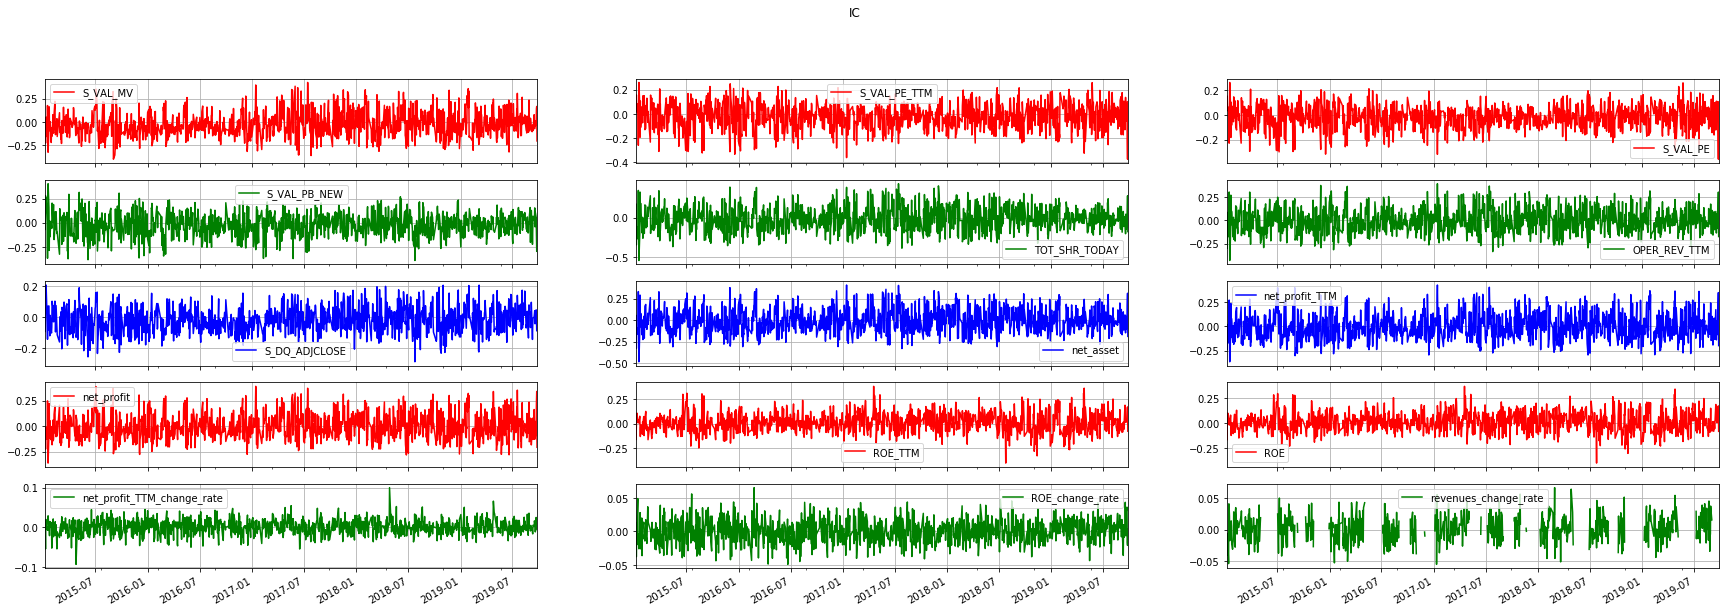

In [128]:
ic.plot(kind='line', subplots=True, grid=True, title="IC",
        layout=(5, 3), sharex=True, sharey=False, legend=True,    
        style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r','g', 'g', 'g'],
        figsize=(30,10)
        )

In [36]:
start_year = 2016
str(start_year)+'0101'

'20160101'

In [37]:
ICIR = pd.DataFrame({'ic':ic.mean(),'ir':ic.mean()/ic.std()})
#ICIR 
#ic.loc["20160101":]
ICIR[str(start_year)+'ic'] = ic.loc[str(start_year)+'0101':].mean()
ICIR[str(start_year)+'ir'] = ic.loc[str(start_year)+'0101':].mean()/ic.loc[str(start_year)+'0101':].std()
#ICIR
ICIR.head()

,ic,ir,2016ic,2016ir
S_VAL_MV,-0.025690,-0.192367,-0.017544,-0.129629
S_VAL_PE_TTM,-0.020643,-0.192068,-0.023728,-0.230721
S_VAL_PE,-0.019679,-0.207682,-0.022029,-0.244969
S_VAL_PB_NEW,-0.021702,-0.181969,-0.022611,-0.203091
TOT_SHR_TODAY,-0.013383,-0.088925,-0.007297,-0.049246


In [91]:
for start_year in range(2016,2020):
    ICIR[str(start_year)+'ic'] = ic.loc[str(start_year)+'0101':].mean()
    ICIR[str(start_year)+'ir'] = ic.loc[str(start_year)+'0101':].mean()/ic.loc[str(start_year)+'0101':].std()

In [92]:
#ICIR
ICIR.head()

,ic,ir,2016ic,2016ir,2017ic,2017ir,2018ic,2018ir,2019ic,2019ir
S_VAL_MV,-0.025690,-0.192367,-0.017544,-0.129629,-0.006427,-0.044908,-0.008776,-0.064511,-0.007519,-0.061334
S_VAL_PE_TTM,-0.020643,-0.192068,-0.023728,-0.230721,-0.023504,-0.234200,-0.016228,-0.152435,-0.014367,-0.123399
S_VAL_PE,-0.019679,-0.207682,-0.022029,-0.244969,-0.020899,-0.240078,-0.015366,-0.168337,-0.012899,-0.125150
S_VAL_PB_NEW,-0.021702,-0.181969,-0.022611,-0.203091,-0.019483,-0.178221,-0.017094,-0.160385,-0.016641,-0.180428
TOT_SHR_TODAY,-0.013383,-0.088925,-0.007297,-0.049246,-0.002803,-0.018545,-0.005671,-0.041604,-0.006720,-0.064915


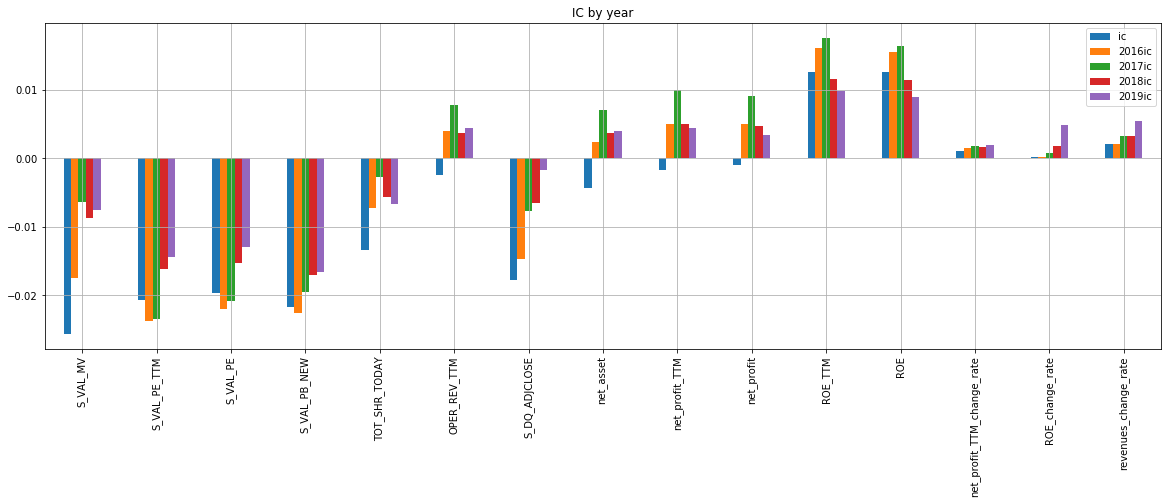

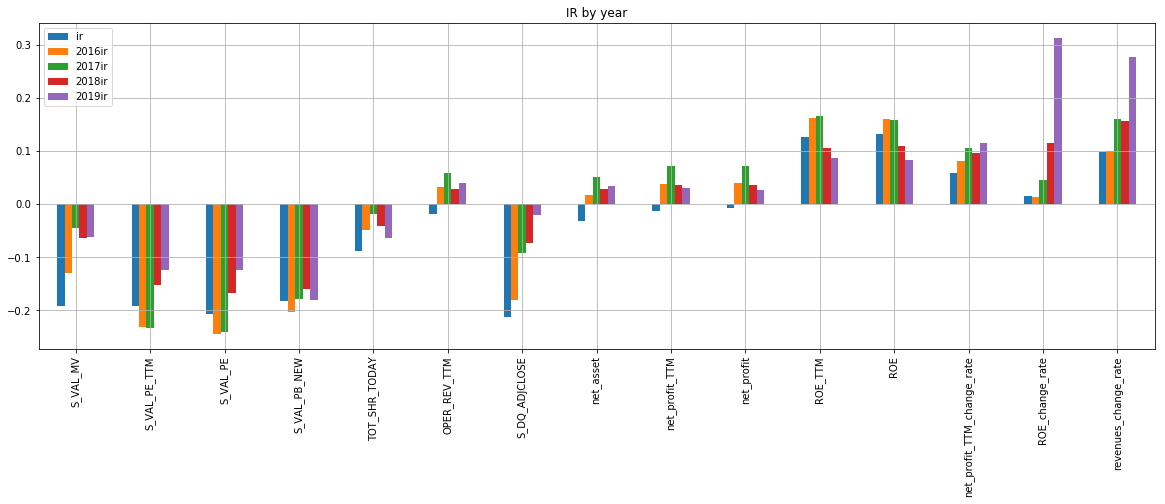

In [98]:
ICIR.iloc[:,np.arange(0,10,2)].plot(kind='bar', grid=True, title="IC by year",
        figsize=(20,6)
        )
ICIR.iloc[:,np.arange(1,11,2)].plot(kind='bar', grid=True, title="IR by year",
        figsize=(20,6)
        )

# Daily Portfolio Returns

In [39]:
def dailylongret(x):
    tmp = data[['stkcd','date','ret(T+1)']].copy()
    tmp['factor_r'] = rank(data[x])
    return tmp.loc[tmp['factor_r']>=0.9]['ret(T+1)'].groupby(data['date']).mean()

def dailyshortret(x):
    tmp = data[['stkcd','date','ret(T+1)']].copy()
    tmp['factor_r'] = rank(data[x])
    return tmp.loc[tmp['factor_r']<=0.1]['ret(T+1)'].groupby(data['date']).mean()

def daily_fac_cost_l(x) :  
    tempp=data[['stkcd','date']].copy()
    tempp['factor_r'] = rank(data[x]).fillna(0)
    tempp['hold'] = (tempp['factor_r'] >=0.9).astype(int)  
    temppindexed = tempp.set_index(['stkcd'])  
    temppindexed['Hold_shift'] = temppindexed.groupby('stkcd')['hold'].shift(1)
    temppindexed['Hold_change'] = abs(temppindexed['hold']-temppindexed['Hold_shift'])
    turnover_rate=(temppindexed.groupby('date')['Hold_change'].sum()/temppindexed.groupby('date')['hold'].sum()).fillna(0)
    where_are_inf = np.isinf(turnover_rate)
    turnover_rate[where_are_inf] = 1
    tcost=turnover_rate*0.0015
    dict_data = {'date':tcost.index, 't-cost':tcost}
    t_cost=pd.DataFrame(dict_data).drop('date', 1)
    t_cost.columns=[x]
    return t_cost

In [44]:
dlcost= pd.DataFrame(dailylongret('ret(T+1)')).drop(columns='ret(T+1)') # get all trading days as index
for i in tqdm(ICIR.index):
    dlcost[i] = daily_fac_cost_l(i)
        
dlr = pd.DataFrame(dailylongret('ret(T+1)')).drop(columns='ret(T+1)') # get all trading days as index
dsr = dlr.copy()

for i in tqdm(ICIR.index):
    dlr[i] = dailylongret(i)
    dsr[i] = dailyshortret(i)

In [159]:
dlr.index  = np.array([datetime.strptime(str(i), '%Y%m%d').date() for i in dlr.index])
dsr.index  = np.array([datetime.strptime(str(i), '%Y%m%d').date() for i in dsr.index])

## 多头收益及对应t值(扣费) 

In [131]:
dlcr = dlr.sub(dlcost)  # ret minus trasaction cost
dlcr['year'] = dlcr.index
dlcr['year'] = dlcr['year'].apply(lambda x:int(int(x)/10000))
dlcr['year'] = dlcr.year
dlcr['year'] = dlcr.year

dlcr.index  = np.array([datetime.strptime(str(i), '%Y%m%d').date() for i in dlcr.index])

dlcr.head()

,OPER_REV_TTM,ROE,ROE_TTM,ROE_change_rate,S_DQ_ADJCLOSE,S_VAL_MV,S_VAL_PB_NEW,S_VAL_PE,S_VAL_PE_TTM,TOT_SHR_TODAY,net_asset,net_profit,net_profit_TTM,net_profit_TTM_change_rate,revenues_change_rate,year
2015-01-05,0.014230,0.019076,0.020268,0.017242,0.017717,0.016416,0.017014,0.016253,0.018789,0.015651,0.014542,0.015957,0.016563,0.017289,0.014943,2015
2015-01-06,-0.000315,-0.004718,-0.004179,-0.001985,-0.002951,-0.002890,-0.000969,0.000234,-0.002312,0.000936,-0.001155,-0.001653,-0.000916,-0.004079,-0.005735,2015
2015-01-07,-0.005607,-0.003301,-0.003182,-0.004446,-0.006491,-0.005817,-0.003092,-0.003958,-0.002583,-0.004411,-0.004885,-0.005331,-0.004939,-0.007639,-0.003135,2015
2015-01-08,-0.007320,-0.007085,-0.006002,-0.008808,-0.007458,-0.005320,-0.007281,-0.008565,-0.007088,-0.007024,-0.007764,-0.005946,-0.006175,-0.008640,-0.007369,2015
2015-01-09,-0.014568,-0.013195,-0.012629,-0.017472,-0.012370,-0.013316,-0.013611,-0.016831,-0.016100,-0.014526,-0.016242,-0.014859,-0.015032,-0.016675,-0.012717,2015


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a9422a20>,
      dtype=object)

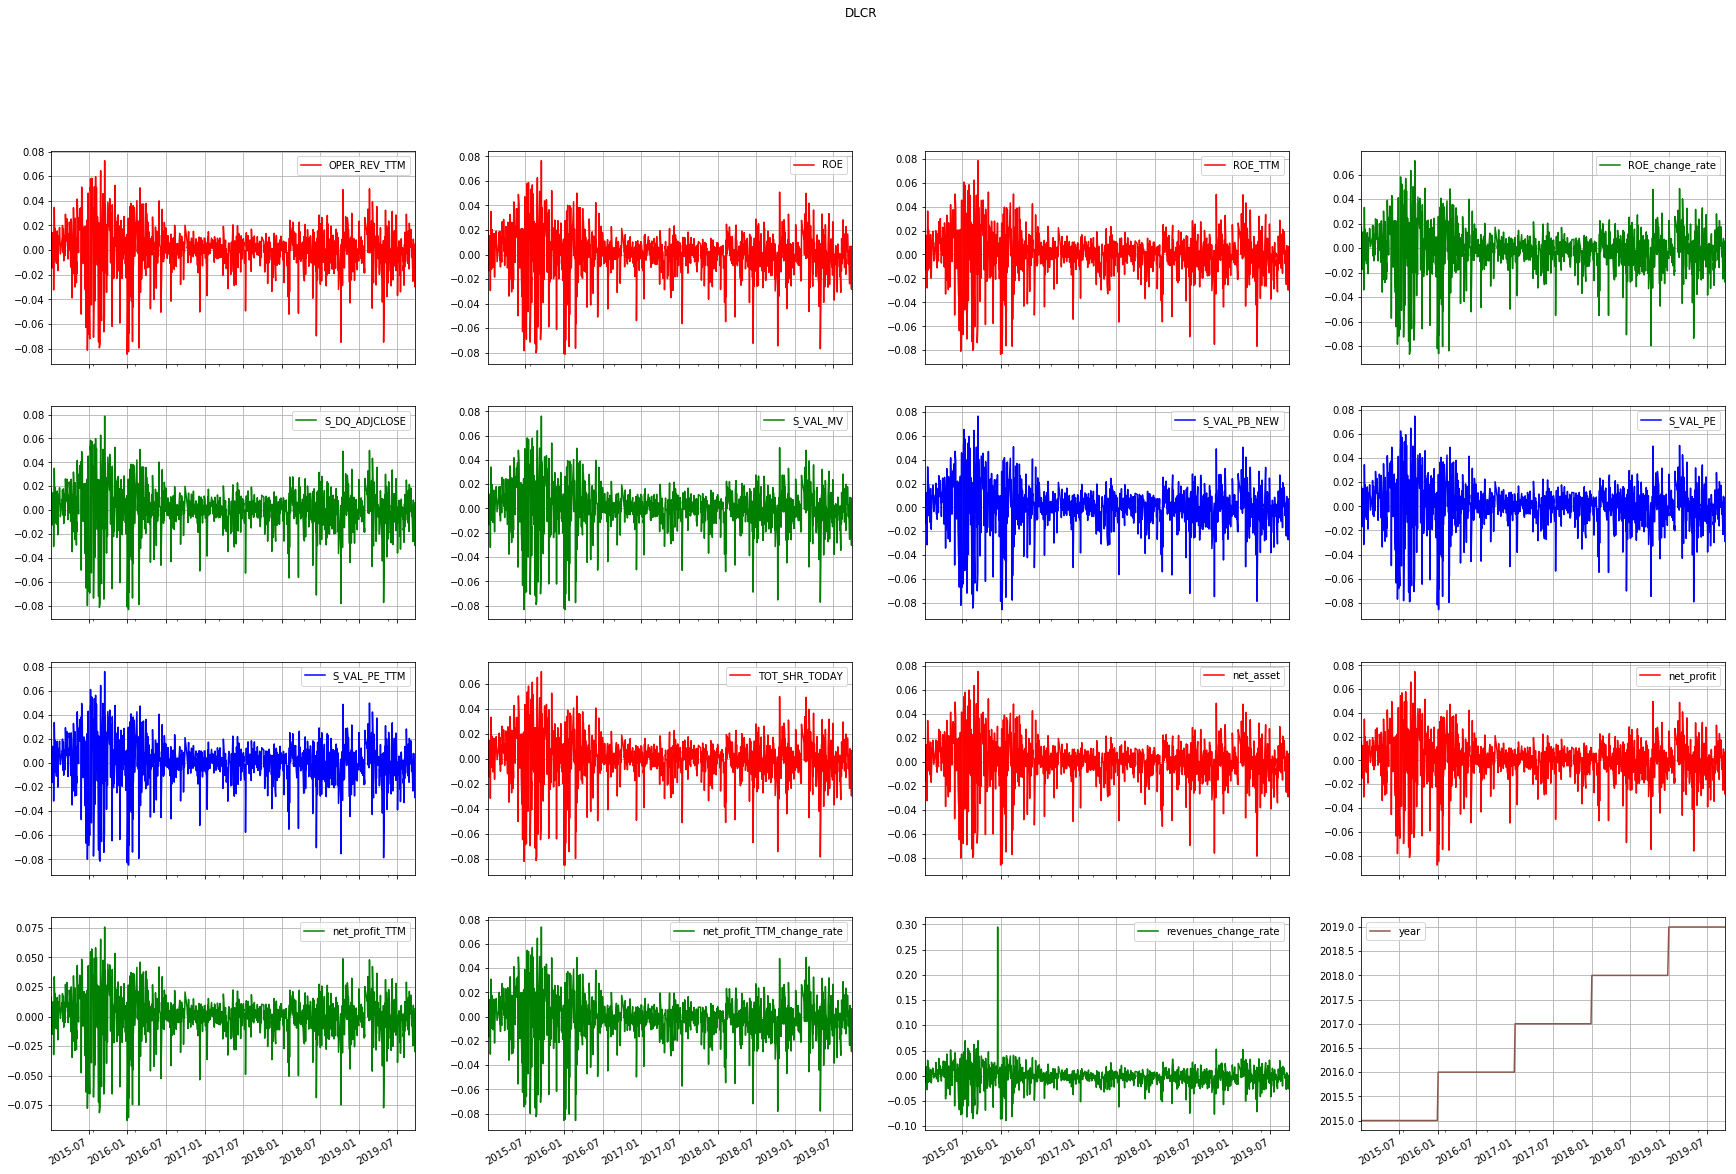

In [132]:
dlcr.plot(kind='line', subplots=True, grid=True, title="DLCR",
        layout=(4, 4), sharex=True, sharey=False, legend=True,    
        style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r','g', 'g', 'g'],
        figsize=(30,20)
        )

## 多空收益及对应t值(不必扣费) 

In [133]:
dlsr = dlr.sub(dsr)
dlr['year'] = dlsr.index
dlr['year'] = dlr['year'].apply(lambda x:int(int(x)/10000))
dsr['year'] = dlr.year
dlsr['year'] = dlr.year

dlsr.index  = np.array([datetime.strptime(str(i), '%Y%m%d').date() for i in dlsr.index])
dlsr.head()

,S_VAL_MV,S_VAL_PE_TTM,S_VAL_PE,S_VAL_PB_NEW,TOT_SHR_TODAY,OPER_REV_TTM,S_DQ_ADJCLOSE,net_asset,net_profit_TTM,net_profit,ROE_TTM,ROE,net_profit_TTM_change_rate,ROE_change_rate,revenues_change_rate,year
2015-01-05,0.000380,0.003121,-0.000365,0.002523,-0.002268,-0.003467,0.001554,-0.001540,-0.000765,-0.000506,0.002395,0.003538,0.001981,0.001554,0.006209,2015
2015-01-06,-0.002410,-0.002786,0.001588,-0.001156,0.001410,0.002207,-0.002354,-0.001883,0.000049,-0.003433,-0.002533,-0.005156,-0.002253,0.002841,0.007093,2015
2015-01-07,-0.003599,0.000601,-0.000917,0.001406,-0.000919,-0.003896,-0.003737,-0.002202,-0.003034,-0.000315,0.000532,0.000843,-0.001486,0.003806,0.010682,2015
2015-01-08,-0.000276,-0.000851,-0.001627,-0.001255,-0.000313,-0.001370,-0.002466,-0.000725,0.000296,0.002955,0.002809,0.001727,0.000100,-0.000170,-0.000524,2015
2015-01-09,-0.000911,-0.000096,-0.001506,0.000924,0.000145,-0.000261,0.002397,-0.002219,0.002037,0.003373,0.003905,0.003727,-0.000982,0.001051,0.003206,2015


In [134]:
dlsr.shape

(1157, 16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a9fc7160>,
      dtype=object)

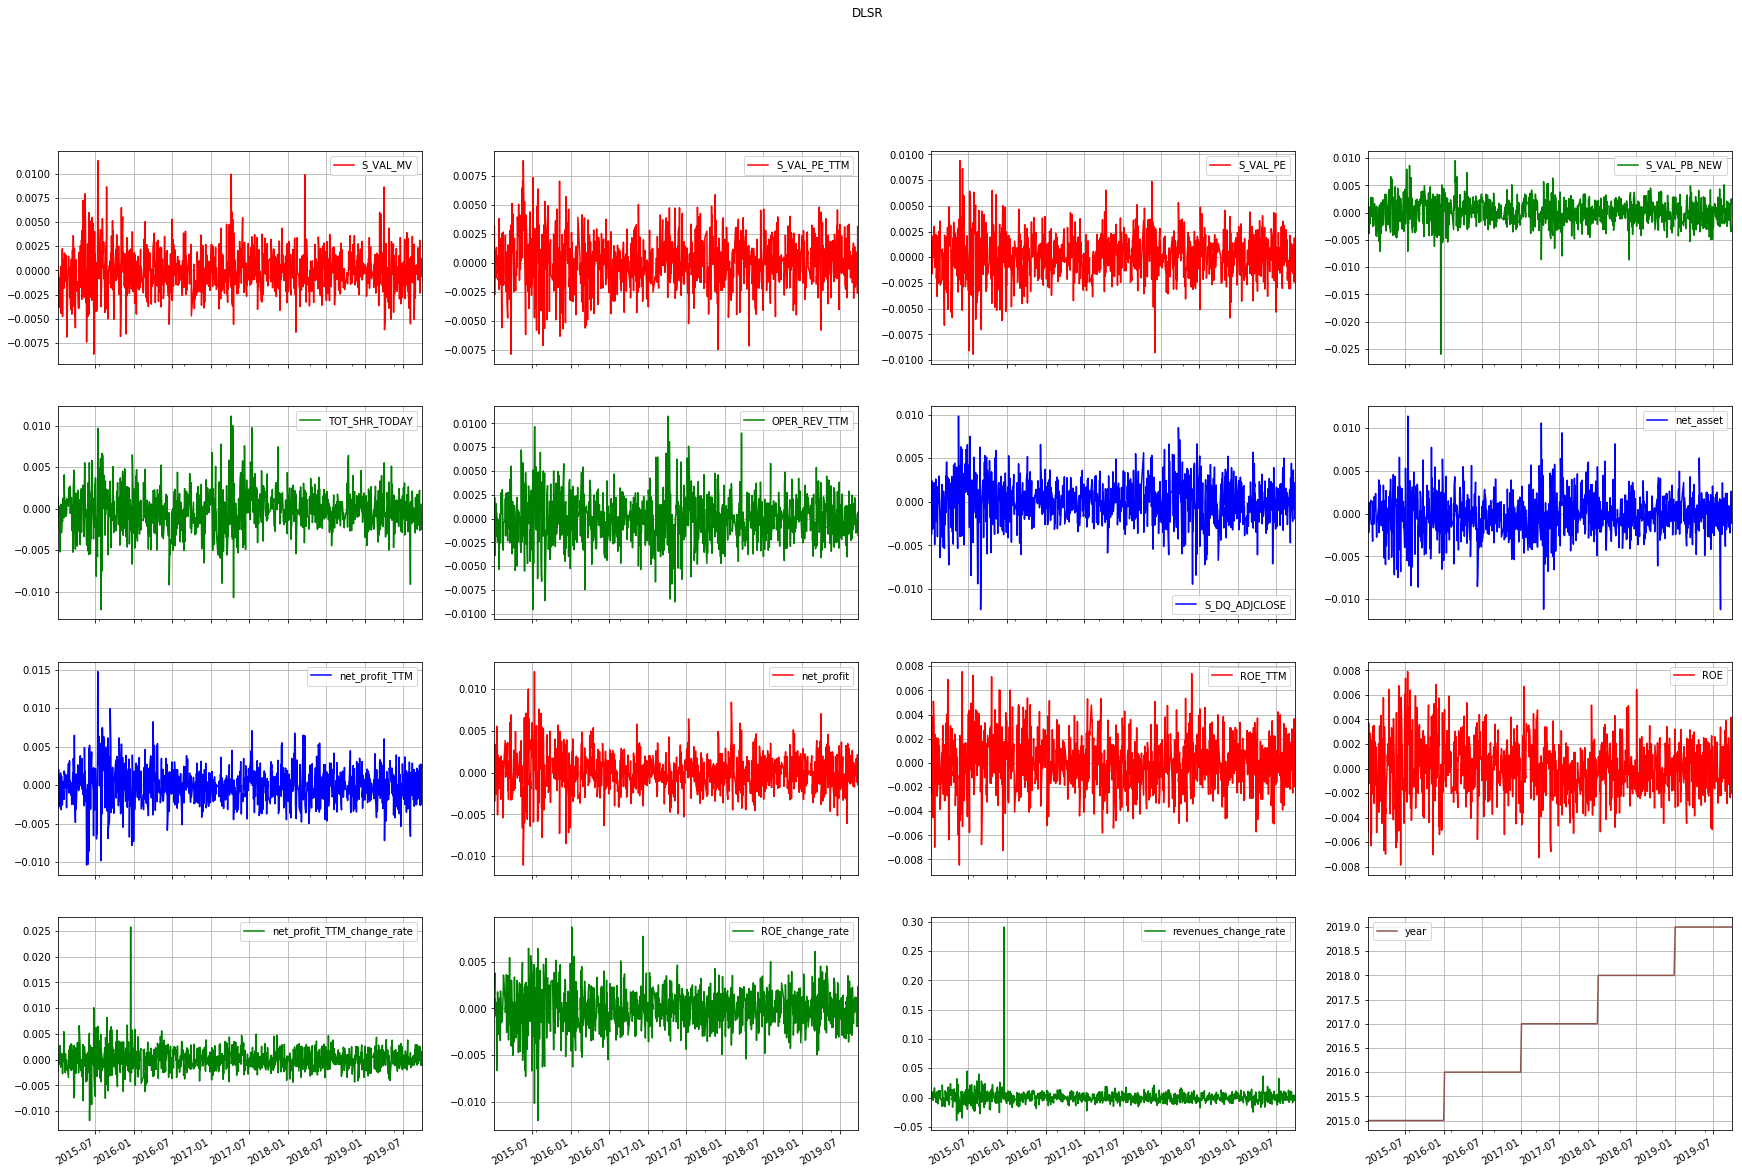

In [135]:
dlsr.plot(kind='line', subplots=True, grid=True, title="DLSR",
        layout=(4, 4), sharex=True, sharey=False, legend=True,    
        style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r','g', 'g', 'g'],
        figsize=(30,20)
        )

## 多头相对中证500收益(扣费)

In [136]:
# Compare Long Portfolio with ZZ500 Index, cost considered
ZZ500 = pd.read_csv('data/mengmengdata/zz500.csv')
ZZ500.sort_values(["Date"],ascending = [True],inplace = True)
ZZ500['retSX'] = (ZZ500.opn.shift(-2)/ZZ500.opn.shift(-1)-1)
ZZ500 = ZZ500[:-737].set_index('Date')

ZZ500.index  = np.array([datetime.strptime(str(i), '%Y%m%d').date() for i in ZZ500.index])
ZZ500.tail()

,opn,retSX
2016-09-08,6489.62,-0.023917
2016-09-09,6518.68,-0.005977
2016-09-12,6362.77,-0.006027
2016-09-13,6324.74,0.000985
2016-09-14,6286.62,0.008248


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1acacf198>,
      dtype=object)

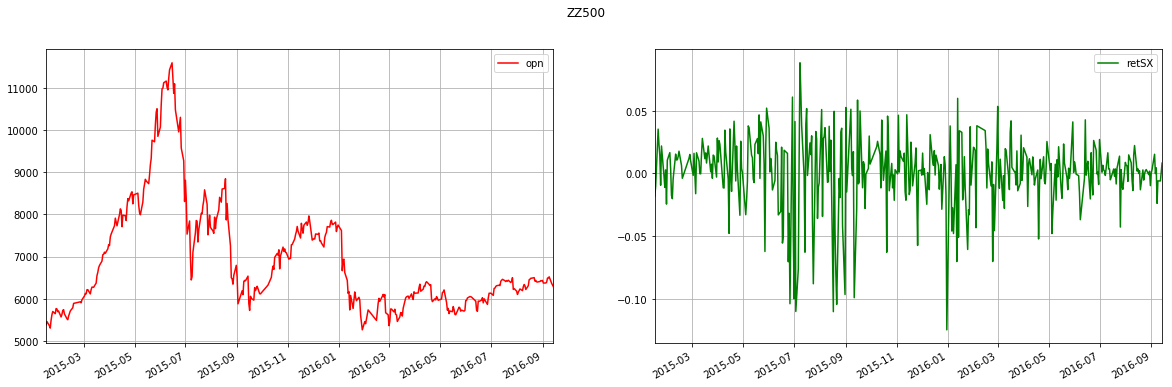

In [140]:
ZZ500.plot(kind='line', subplots=True, grid=True, title="ZZ500",
        layout=(1, 2), sharex=True, sharey=False, legend=True,    
        style=['r', 'g'],
        figsize=(20,6)
        )

In [146]:
comparezz=dlcr.sub(ZZ500.retSX,axis=0)
#comparezz.index  = np.array([datetime.strptime(str(i), '%Y%m%d').date() for i in comparezz.index])
comparezz.tail()

,OPER_REV_TTM,ROE,ROE_TTM,ROE_change_rate,S_DQ_ADJCLOSE,S_VAL_MV,S_VAL_PB_NEW,S_VAL_PE,S_VAL_PE_TTM,TOT_SHR_TODAY,net_asset,net_profit,net_profit_TTM,net_profit_TTM_change_rate,revenues_change_rate,year
2019-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b032f550>,
      dtype=object)

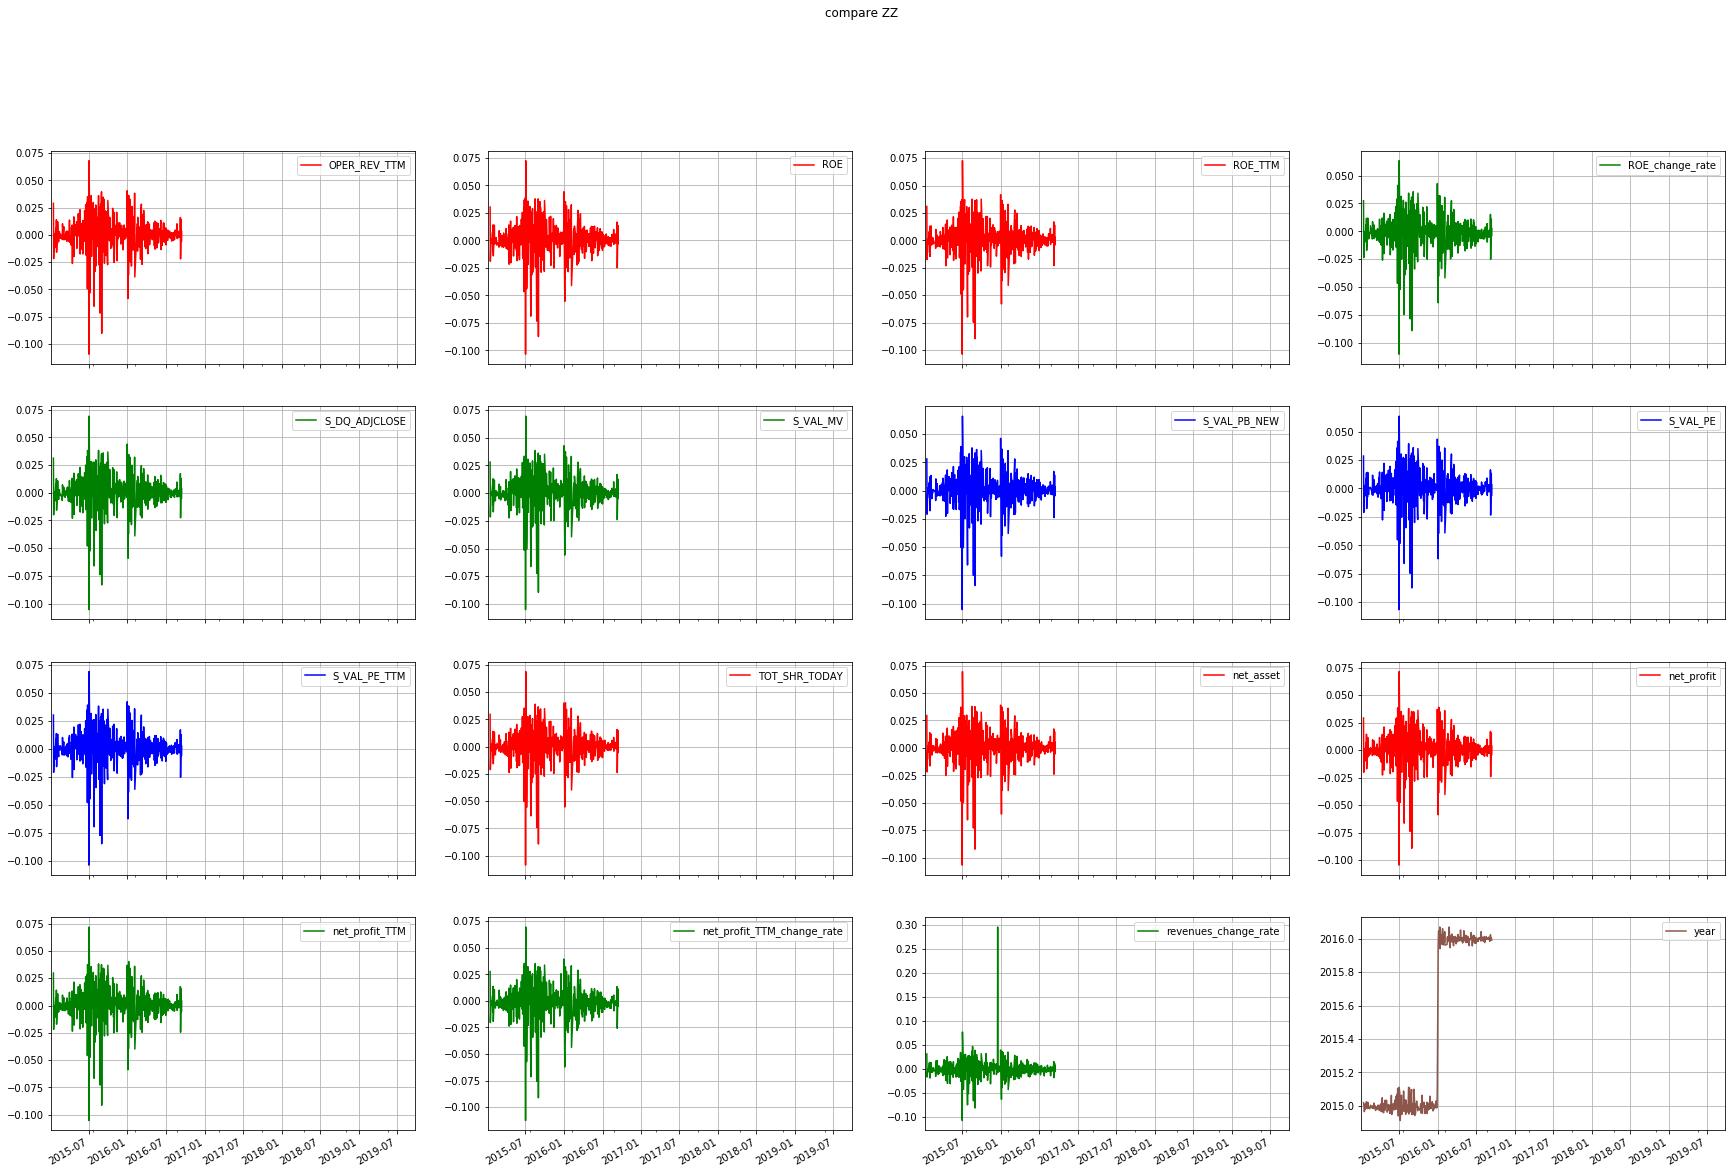

In [145]:
comparezz.plot(kind='line', subplots=True, grid=True, title="compare ZZ",
        layout=(4, 4), sharex=True, sharey=False, legend=True,    
        style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r','g', 'g', 'g'],
        figsize=(30,20)
        )

In [148]:
def CumRet_T(df):
    CumRet = df.groupby('year').sum()
    tvalue = sqrt(df.groupby('year').count()).mul(df.groupby('year').mean()).div(df.groupby('year').std())  
    Rep = CumRet.append(tvalue).T   
    #Rep.columns=['2015','2016','t2015','t2016'] # hard code似乎有问题，不要这么写
    Rep.columns=np.concatenate((np.array(CumRet.index),np.array(['t'+str(i) for i in CumRet.index])))
    return Rep

In [163]:
comparezz['year'] = dlr.year
reportlczz = CumRet_T(comparezz)
reportlczz.head()

,2015,2016,2017,2018,2019,t2015,t2016,t2017,t2018,t2019
OPER_REV_TTM,0.206770,-0.001667,0.0,0.0,0.0,0.715167,-0.010458,NaN,NaN,NaN
ROE,0.254479,0.053379,0.0,0.0,0.0,0.881331,0.337181,NaN,NaN,NaN
ROE_TTM,0.260898,0.050608,0.0,0.0,0.0,0.896329,0.317108,NaN,NaN,NaN
ROE_change_rate,-0.267145,-0.421232,0.0,0.0,0.0,-0.919894,-2.579440,NaN,NaN,NaN
S_DQ_ADJCLOSE,0.265747,0.013460,0.0,0.0,0.0,0.928618,0.086435,NaN,NaN,NaN


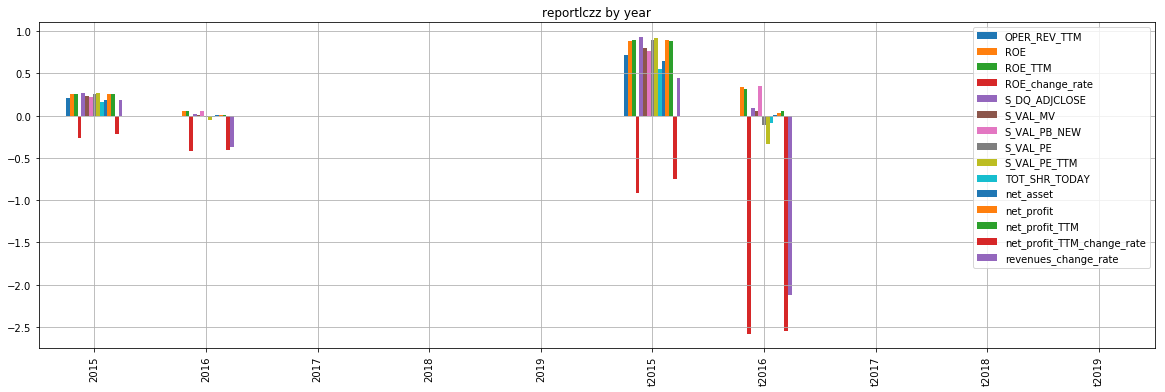

In [166]:
reportlczz.iloc[:,].T.plot(kind='bar', grid=True, title="reportlczz by year",
        figsize=(20,6)
        )


In [161]:
reportdlcr = CumRet_T(dlcr)
reportdlcr 

,2015,2016,2017,2018,2019,t2015,t2016,t2017,t2018,t2019
OPER_REV_TTM,0.545228,0.009079,-0.158099,-0.409477,-0.135715,1.189026,0.030850,-1.025014,-1.693416,-0.603335
ROE,0.596632,0.083665,-0.147842,-0.433280,-0.119569,1.310951,0.280898,-0.878099,-1.768523,-0.527558
ROE_TTM,0.606762,0.073381,-0.170902,-0.419317,-0.124226,1.325166,0.247006,-1.015816,-1.715422,-0.550718
ROE_change_rate,0.061828,-0.560493,-0.714306,-0.987184,-0.239040,0.134481,-1.869158,-4.436264,-4.023834,-1.074906
S_DQ_ADJCLOSE,0.605855,0.028469,-0.149803,-0.356903,-0.140899,1.304458,0.097187,-0.916867,-1.360796,-0.622309
S_VAL_MV,0.568651,0.018307,-0.162615,-0.423447,-0.152557,1.239507,0.061698,-1.015677,-1.740975,-0.675918
S_VAL_PB_NEW,0.563549,0.062913,-0.148789,-0.389783,-0.139137,1.222364,0.211346,-0.871056,-1.560641,-0.616367
S_VAL_PE,0.597452,0.022668,-0.048128,-0.399111,-0.108798,1.295784,0.076581,-0.298410,-1.598834,-0.479740
S_VAL_PE_TTM,0.608617,-0.041331,-0.056019,-0.423593,-0.100104,1.319923,-0.140020,-0.336772,-1.681291,-0.442187
TOT_SHR_TODAY,0.502577,0.016243,-0.140368,-0.437391,-0.153726,1.106087,0.055234,-0.873380,-1.857253,-0.677157


In [162]:
reportdlsr = CumRet_T(dlsr)
reportdlsr

,2015,2016,2017,2018,2019,t2015,t2016,t2017,t2018,t2019
S_VAL_MV,-0.010049,-0.054279,0.013472,-0.023865,-0.027158,-0.217533,-1.870694,0.430743,-0.848655,-0.936104
S_VAL_PE_TTM,0.064327,-0.066925,0.059201,-0.018310,0.042047,1.409852,-2.304974,1.891101,-0.608263,1.766791
S_VAL_PE,0.041566,-0.000699,0.066340,0.022162,0.019578,0.889376,-0.025719,2.116682,0.815391,0.804610
S_VAL_PB_NEW,0.054662,0.071301,-0.005358,0.020537,-0.018728,1.069343,2.240270,-0.149988,0.686473,-0.677950
TOT_SHR_TODAY,-0.036904,-0.142675,0.043892,-0.002695,-0.051492,-0.791958,-4.049472,0.940626,-0.104092,-1.983364
OPER_REV_TTM,0.000641,-0.035283,-0.046459,-0.007117,-0.026658,0.013405,-1.148250,-1.010139,-0.241154,-1.058659
S_DQ_ADJCLOSE,0.068310,0.038239,0.029823,-0.006298,-0.047232,1.374653,1.341933,1.000696,-0.132651,-1.706777
net_asset,-0.032762,-0.115945,0.007187,-0.041421,-0.021680,-0.691385,-3.659456,0.158637,-1.378209,-0.787976
net_profit_TTM,0.045906,0.033079,-0.037265,-0.051107,-0.037495,0.865211,1.048493,-1.270134,-1.456962,-1.353844
net_profit,0.076268,0.011166,-0.047289,-0.019867,-0.010968,1.483076,0.379122,-1.764264,-0.607728,-0.399621
